In [6]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from Functions import Transfer_graphs,preformance_graph_and_prep_2nd_set,create_std_matrix,unpack_dic,create_dictionaries,make_distance_graph

In [13]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
loud=[0,1,0,0,0,1]
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],'topology']]=data[['MOF ID',interest[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],'topology', 'Pc1', 'Pc2', 'Cluster']]

# generate Cluster data sets 
Cluster0=abridge[abridge["Cluster"]==0]
Cluster1=abridge[abridge["Cluster"]==1]
Cluster2=abridge[abridge["Cluster"]==2]
Cluster3=abridge[abridge["Cluster"]==3]
Cluster4=abridge[abridge["Cluster"]==4]
Cluster5=abridge[abridge["Cluster"]==5]
# generate holder for dataframes for looping 
M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]
O_M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]
s_M_Cluster=size_clusters(M_Cluster)
# parameters for neural net
epochs = 500
batch_size = 128
input_size = 5
output_size = 1
resolution=50
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
#Base Cluster for transfer learning 
#specify cluster
cluster=0
data = Cluster0
#checks for index problem
data = data.reset_index(drop=True)
#computer requirements 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = os.getcwd()

features = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
#create splits 
df_train,df_val,df_test=prep_data_splits(data,features,interest)
#create dataset loader objects for looping through data,default test size is .2
first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

third = MyDataset(df_test, interest, features)
test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
#intialize holders for data
train_loss = []
train_r_2 = []
val_loss = []
val_r_2 = []
test_loss = []
test_r_2 = []
net_time = []

# initalize model
model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
criterion = nn.MSELoss()
learning_rate = trial_parameters["lr"]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#Create engine for running NN, pytorch

def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x.to(device))
    loss = criterion(y_pred.to(device), y.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)
#sets up loss and R scores and stores values
#Note: note sure if can condense this into a module b/c of decorator and namespace

@trainer.on(Events.EPOCH_COMPLETED(every=50))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train.to(device)),train_loader.dataset.y_train.to(device)))
    out1=float(r2_score(model(train_loader.dataset.x_train.to(device)).detach().numpy(),train_loader.dataset.y_train.to(device).detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train.to(device)),val_loader.dataset.y_train.to(device)))
    out3=float(r2_score(model(val_loader.dataset.x_train.to(device)).detach().numpy(),val_loader.dataset.y_train.to(device).detach().numpy()))
    out4=float(criterion(model(test_loader.dataset.x_train.to(device)),test_loader.dataset.y_train.to(device)))
    out5=float(r2_score(model(test_loader.dataset.x_train.to(device)).detach().numpy(),test_loader.dataset.y_train.to(device).detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    test_loss.append(out4)
    test_r_2.append(out5)
    net_time.append(end-start)
    if loud[2]:
        print(e)
#Creates timer and runs trainer 
start = time.time()
trainer.logger.disabled=True
trainer.run(train_loader, max_epochs=epochs)
plt.show()

if loud[3]:
    plt.plot(val_r_2)
    plt.plot(train_r_2,label="t")
    plt.plot(test_r_2,label="real")
    plt.legend()
    plt.show()
    plt.plot(val_loss)
    plt.plot(train_loss,label="t")
    plt.plot(test_loss,label="real")
    plt.legend()
    plt.show()
#save base model for transfer into other clusters in loop
torch.save(model, "Temp.ckpt")
#transfer learning part
#stores meta data
test_loss_holder=[]
test_r2_holder=[]
#loops through clusters
for count,i in enumerate(M_Cluster):
    train_loss = []
    train_r_2 = []
    val_loss = []
    val_r_2 = []
    test_loss = []
    test_r_2 = []
    net_time = []
    #loading model again
    model=torch.load("Temp.ckpt")
    descriptor_columns = [
        "void fraction",
        "Vol. S.A.",
        "Grav. S.A.",
        "Pore diameter Limiting",
        "Pore diameter Largest",
    ]
#turns off model learning
    model.fc1.weight.requires_grad = False
    model.fc1.bias.requires_grad = False
    model.fc2.weight.requires_grad = False
    model.fc2.bias.requires_grad = False

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
    )
    #Base Cluster for transfer learning 
    data = i
    #checks for index problem
    data = data.reset_index(drop=True)
    df_train,df_val,df_test=prep_data_splits(data,features,interest)
    #create dataset loader objects for looping through data,default test size is .2
    first = MyDataset(df_train, interest, features)
    train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

    second = MyDataset(df_val, interest, features)
    val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

    third = MyDataset(df_test, interest, features)
    test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

    #once again making training and testing engine
    def train_step_1(engine, batch):
        x, y = batch
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        return loss.item()


    transfer_trainer = Engine(train_step_1)
    n=int(epochs/resolution)
    @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
    def store_metrics(engine):
        e = engine.state.epoch
        end=time.time()
        out=float(criterion(model(train_loader.dataset.x_train.to(device)),train_loader.dataset.y_train.to(device)))
        out1=float(r2_score(model(train_loader.dataset.x_train.to(device),train_loader.dataset.y_train.to(device)))
        out2=float(criterion(model(val_loader.dataset.x_train.to(device)),val_loader.dataset.y_train.to(device)))
        out3=float(r2_score(model(val_loader.dataset.x_train.to(device)),val_loader.dataset.y_train.to(device)))
        out4=float(criterion(model(test_loader.dataset.x_train.to(device)),test_loader.dataset.y_train.to(device)))
        out5=float(r2_score(model(test_loader.dataset.x_train.to(device)),test_loader.dataset.y_train.to(device)))
        end=
        train_loss.append(out)
        train_r_2.append(out1)
        val_loss.append(out2)
        val_r_2.append(out3)
        test_loss.append(out4)
        test_r_2.append(out5)
        net_time.append(end-start)
        if loud[4]:
            print(e)
    #runs model
    transfer_trainer.logger.disabled=True
    transfer_trainer.run(train_loader, max_epochs=epochs)
    test_loss_holder.append(test_loss)
    test_r2_holder.append(test_r_2)
#plots all clusers learning in terms of test set
if loud[5]:
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_loss_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()
    plt.show()
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_r2_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()

SyntaxError: invalid syntax (<ipython-input-13-09cce12fccf0>, line 214)

In [7]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
loud=[0,0,0,0,0,0]
#make clusters the same size with a random sample
resize=True
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],'topology']]=data[['MOF ID',interest[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],'topology', 'Pc1', 'Pc2', 'Cluster']]

# generate Cluster data sets 
Cluster0=abridge[abridge["Cluster"]==0]
Cluster1=abridge[abridge["Cluster"]==1]
Cluster2=abridge[abridge["Cluster"]==2]
Cluster3=abridge[abridge["Cluster"]==3]
Cluster4=abridge[abridge["Cluster"]==4]
Cluster5=abridge[abridge["Cluster"]==5]
# generate holder for dataframes for looping 
O_M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]
#
# parameters for neural net
epochs = 500
resolution=500
batch_size = 128
input_size = 5
output_size = 1
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
#Base Cluster for transfer learning 
#specify cluster
meta_trials=100
meta=[]
for final,i in enumerate(range(meta_trials)):
    #create holder for meta anaylsis
    mega={}
    if resize:
        M_Cluster=size_clusters(O_M_Cluster)
    else:
        M_Cluster=O_M_Cluster
    for i in range(len(M_Cluster)):
        mega[i]=[]
    for count,g in enumerate(M_Cluster):
        cluster=count
        data = g
        #checks for index problem
        data = data.reset_index(drop=True)
        #computer requirements 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #gpu not supported, problem with r2 never solved
        device=torch.device("cpu")
        base_path = os.getcwd()

        features = [
            "void fraction",
            "Vol. S.A.",
            "Grav. S.A.",
            "Pore diameter Limiting",
            "Pore diameter Largest",
        ]
        #create splits 
        df_train,df_val,df_test=prep_data_splits(data,features,interest)
        #create dataset loader objects for looping through data,default test size is .2
        first = MyDataset(df_train, interest, features)
        train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

        second = MyDataset(df_val, interest, features)
        val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

        third = MyDataset(df_test, interest, features)
        test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
        #intialize holders for data
        train_loss = []
        train_r_2 = []
        val_loss = []
        val_r_2 = []
        test_loss = []
        test_r_2 = []
        net_time = []

        # initalize model
        model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
        criterion = nn.MSELoss()
        learning_rate = trial_parameters["lr"]
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        #Create engine for running NN, pytorch

        def train_step(engine, batch):
            x, y = batch
            model.train()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            return loss.item()

        trainer = Engine(train_step)
        #sets up loss and R scores and stores values
        #Note: note sure if can condense this into a module b/c of decorator and namespace
        @trainer.on(Events.EPOCH_COMPLETED(every=50))
        def store_metrics(engine):
            end = time.time()
            e = engine.state.epoch
            out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
            out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
            out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
            out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
            out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
            out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
            train_loss.append(out)
            train_r_2.append(out1)
            val_loss.append(out2)
            val_r_2.append(out3)
            test_loss.append(out4)
            test_r_2.append(out5)
            net_time.append(end-start)
            if loud[2]:
                print(e)
        #Creates timer and runs trainer 
        start = time.time()
        trainer.logger.disabled=True
        trainer.run(train_loader, max_epochs=epochs)
        plt.show()

        if loud[3]:
            plt.plot(val_r_2)
            plt.plot(train_r_2,label="t")
            plt.plot(test_r_2,label="real")
            plt.legend()
            plt.show()
            plt.plot(val_loss)
            plt.plot(train_loss,label="t")
            plt.plot(test_loss,label="real")
            plt.legend()
            plt.show()
        #save base model for transfer into other clusters in loop
        torch.save(model, "Temp2.ckpt")
        #transfer learning part
        #stores meta data
        test_loss_holder=[]
        test_r2_holder=[]
        #loops through clusters
        for count,i in enumerate(M_Cluster):
            train_loss = []
            train_r_2 = []
            val_loss = []
            val_r_2 = []
            test_loss = []
            test_r_2 = []
            net_time = []
            #loading model again
            model=torch.load("Temp2.ckpt")
            descriptor_columns = [
                "void fraction",
                "Vol. S.A.",
                "Grav. S.A.",
                "Pore diameter Limiting",
                "Pore diameter Largest",
            ]
        #turns off model learning
            model.fc1.weight.requires_grad = False
            model.fc1.bias.requires_grad = False
            model.fc2.weight.requires_grad = False
            model.fc2.bias.requires_grad = False

            optimizer = optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
            )
            #Base Cluster for transfer learning 
            data = i
            #checks for index problem
            data = data.reset_index(drop=True)
            df_train,df_val,df_test=prep_data_splits(data,features,interest)
            #create dataset loader objects for looping through data,default test size is .2
            first = MyDataset(df_train, interest, features)
            train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

            second = MyDataset(df_val, interest, features)
            val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

            third = MyDataset(df_test, interest, features)
            test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

            #once again making training and testing engine
            def train_step_1(engine, batch):
                x, y = batch
                model.train()
                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                return loss.item()


            transfer_trainer = Engine(train_step_1)
            n=int(epochs/resolution)
            @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
            def store_metrics(engine):
                end = time.time()
                e = engine.state.epoch
                out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
                out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
                out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
                out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
                out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
                out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
                train_loss.append(out)
                train_r_2.append(out1)
                val_loss.append(out2)
                val_r_2.append(out3)
                test_loss.append(out4)
                test_r_2.append(out5)
                net_time.append(end-start)
                if loud[4]:
                    print(e)
            #runs model
            transfer_trainer.logger.disabled=True
            transfer_trainer.run(train_loader, max_epochs=epochs)
            test_loss_holder.append(test_loss)
            test_r2_holder.append(test_r_2)
        #because error tends to be low, only anaylizing r2 scores
            mega[count].append(test_r_2)
        #plots all clusers learning in terms of test set
        if loud[5]:
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_loss_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
            plt.show()
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_r2_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
    meta.append(mega)
    print(final)

/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

0


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

KeyboardInterrupt: 

In [3]:
len(meta)

1

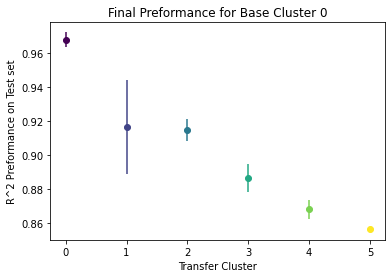

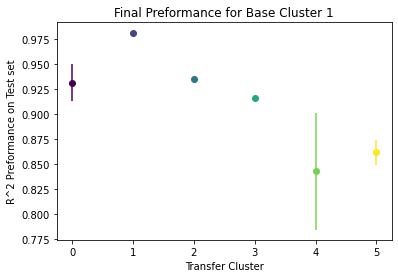

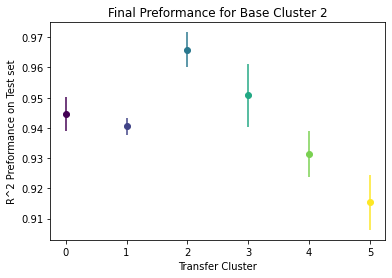

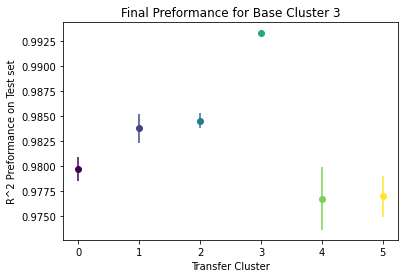

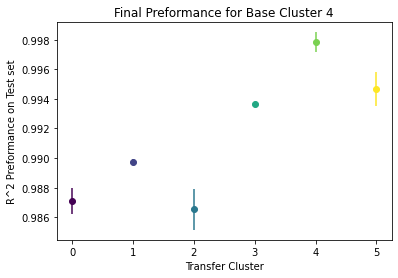

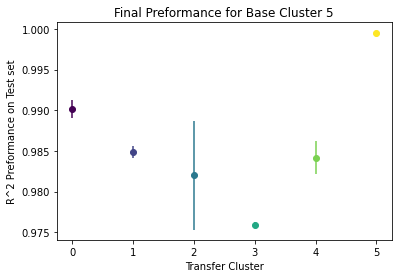

error (0, 0)
19.20927093975322 22.331904185935308 32.0 32.0
205.21993475509984 228.0205720074968 113.0 113.0
731.3847297293491 889.6517361645034 142.0 142.0
3080.8468033946865 3980.597020758751 251.0 251.0
762.6405044195623 935.1315443035811 321.0 321.0


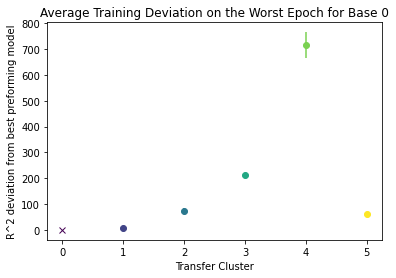

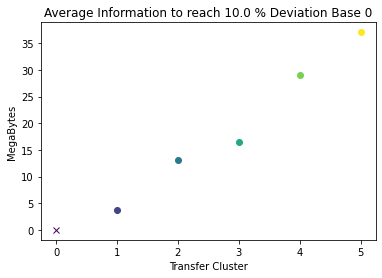

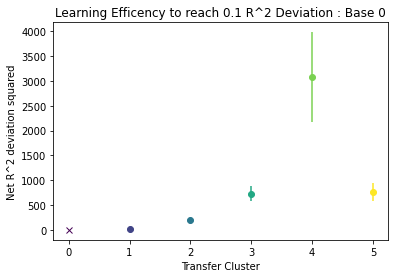

19.889921858897893 25.1572684032161 59.0 59.0
0.0 0.0 2.0 2.0
52.54205275872095 54.61714941423279 40.0 40.0
232.2912154863415 253.1011724702406 110.0 110.0
2751.306177801098 3918.430545639335 172.0 172.0
1209.6646576629382 1578.8719536979168 180.0 180.0


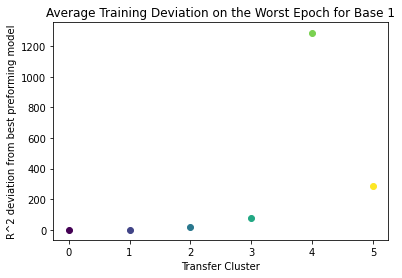

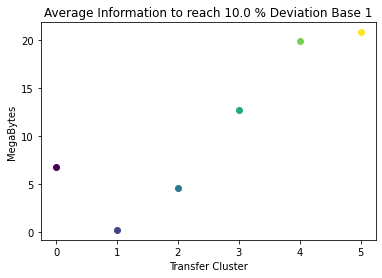

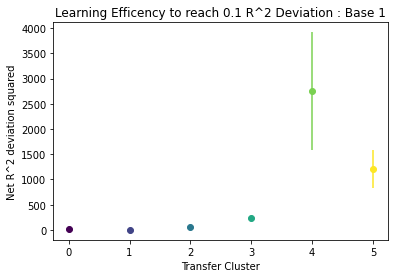

35.87741145878643 38.59561236804152 73.0 73.0
6.304073741458199 7.163089609999692 23.0 23.0
error (2, 2)
8.787420026137822 9.382999863337517 5.0 5.0
202.45409779565307 245.5909784976741 81.0 81.0
368.2660040472148 438.1852905215171 215.0 215.0


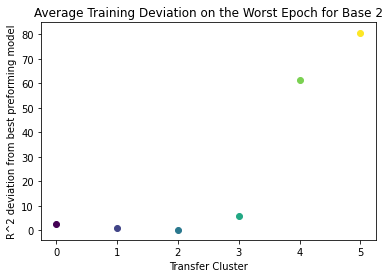

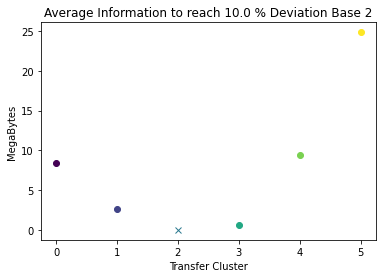

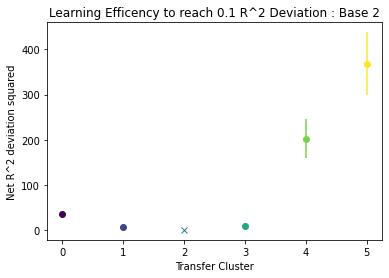

51.88465628323748 55.559436173979655 113.0 113.0
12.655496581737669 13.390577942702572 33.0 33.0
2.7097088947180925 2.8719851304860144 10.0 10.0
error (3, 3)
36.64568387770525 39.69494425470665 40.0 40.0
100.13865045110128 106.33787075433149 164.0 164.0


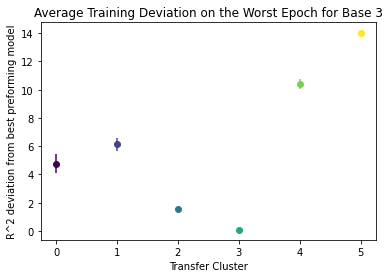

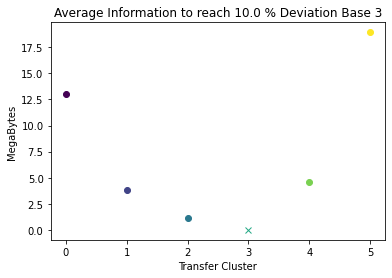

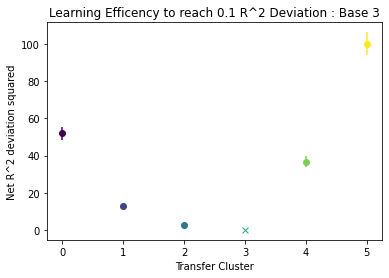

91.93387444162937 95.54712653140085 100.0 100.0
60.34745182184447 66.83655548849966 23.0 23.0
43.82005059618294 46.73084158360524 24.0 24.0
6.141881151187958 6.489852979887913 18.0 18.0
error (4, 4)
21.56913709602602 22.9094773728223 84.0 84.0


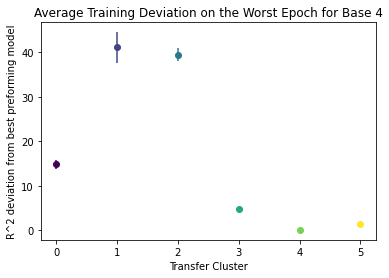

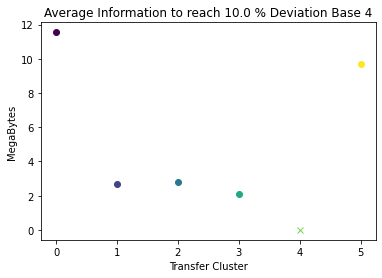

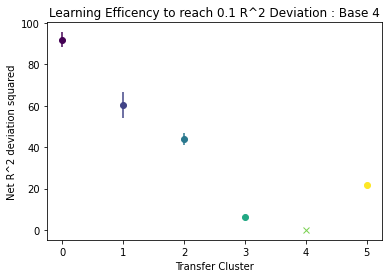

101.13617926962279 107.79353241290178 64.0 64.0
138.1797363098203 147.6224941092291 35.0 35.0
182.61144206465335 195.7263646289947 87.0 87.0
41.83159706654725 44.80095803495307 52.0 52.0
11.85387724402966 13.45366861373107 43.0 43.0
error (5, 5)


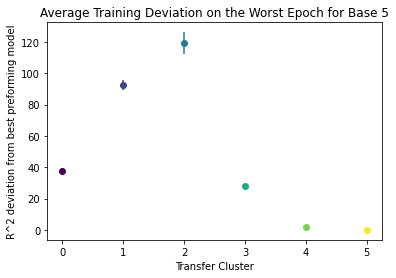

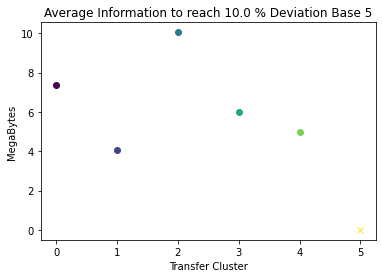

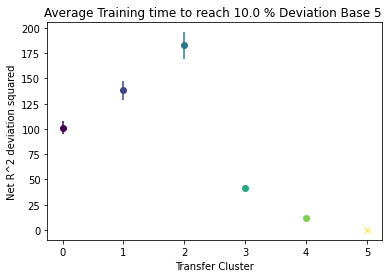

,Pc1,Pc2
Cluster,,
0,-3.544039,3.418156
1,-2.759969,0.638465
2,-1.570916,-0.855064
3,-0.129714,-0.473748
4,1.291237,-0.044567
5,2.664458,0.756521


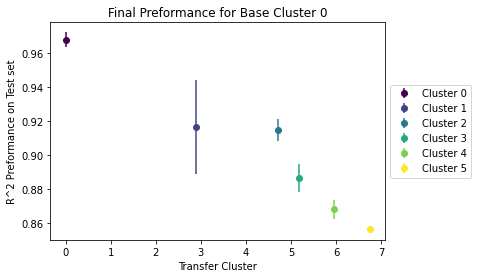

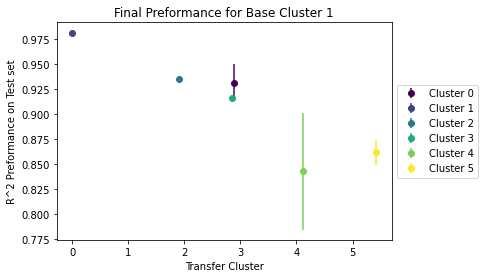

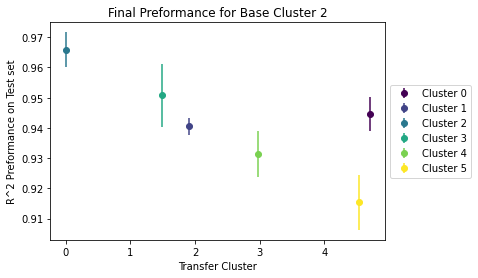

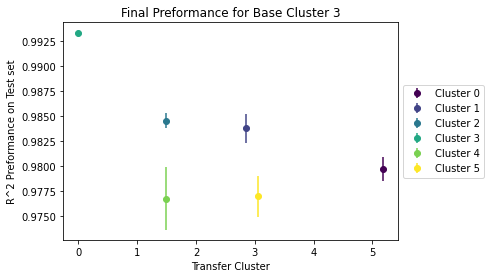

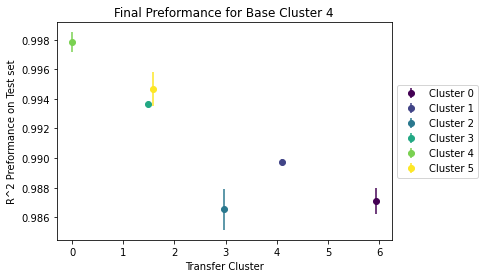

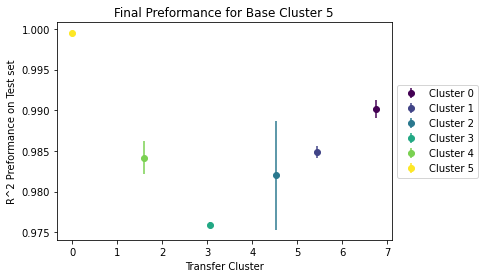

,Pc1,Pc2
Cluster,,
0,-3.544039,3.418156
1,-2.759969,0.638465
2,-1.570916,-0.855064
3,-0.129714,-0.473748
4,1.291237,-0.044567
5,2.664458,0.756521


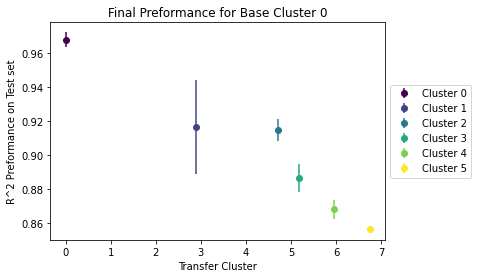

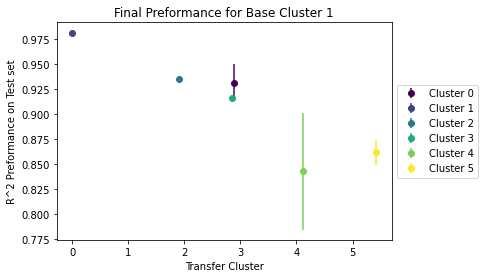

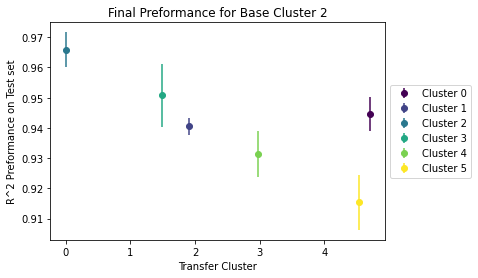

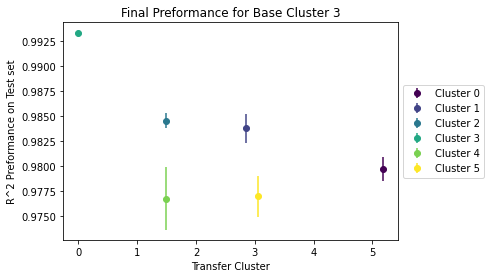

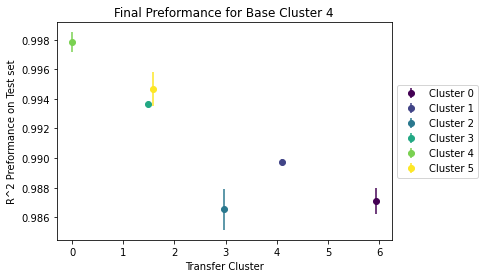

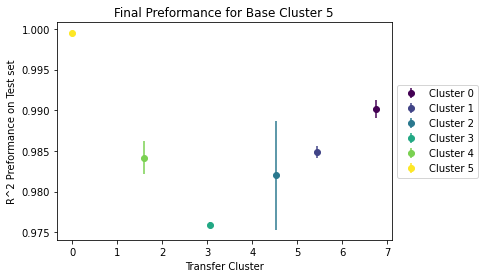

,Pc1,Pc2
Cluster,,
0,-3.544039,3.418156
1,-2.759969,0.638465
2,-1.570916,-0.855064
3,-0.129714,-0.473748
4,1.291237,-0.044567
5,2.664458,0.756521


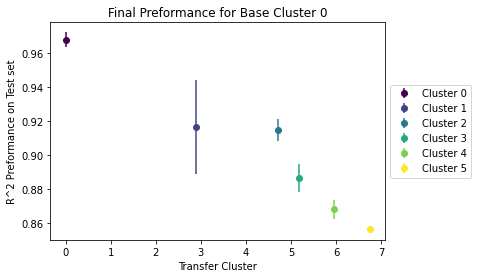

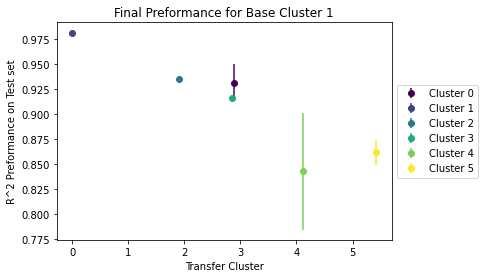

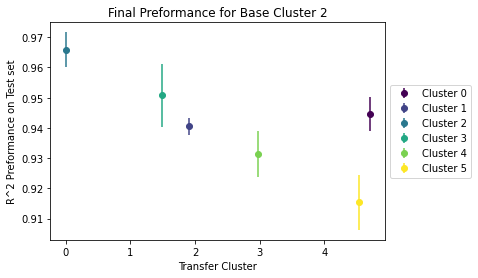

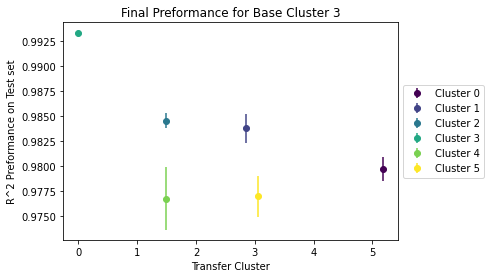

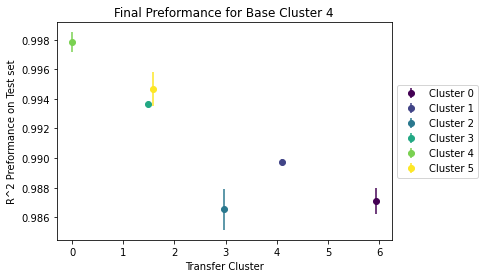

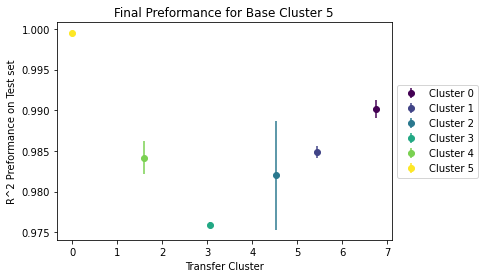

In [8]:
Cluster_colors=[
[0.267004, 0.004874, 0.329415, 1.      ],
[0.253935, 0.265254, 0.529983, 1.      ],
[0.163625, 0.471133, 0.558148, 1.      ],
[0.134692, 0.658636, 0.517649, 1.      ],
[0.477504, 0.821444, 0.318195, 1.      ],
[0.993248, 0.906157, 0.143936, 1.      ],]
dic,dic2,std=create_dictionaries(6)
dic=unpack_dic(dic,meta)
std=create_std_matrix(dic,std)
dic2=preformance_graph_and_prep_2nd_set(Cluster_colors,dic,dic2,adjust=1)
epoch_conversions=[]
byte=df_train.iloc[0].memory_usage()
for i in M_Cluster:
    epoch_conversions.append(len(i))
Transfer_graphs(dic2,resolution,epoch_conversions,Cluster_colors,byte,std,epochs)
import pandas as pd
from scipy.spatial import distance_matrix
hold=pd.DataFrame()
hold[['Pc1', 'Pc2',"Cluster"]]=abridge[['Pc1', 'Pc2',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
make_distance_graph(dic,distances,Cluster_colors)
hold[['Pc1',"Cluster"]]=abridge[['Pc1',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
make_distance_graph(dic,distances,Cluster_colors)
hold[['Pc2',"Cluster"]]=abridge[['Pc2',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
make_distance_graph(dic,distances,Cluster_colors)

In [12]:
import itertools
indexer=itertools.product(range(6),range(6))
dic={}
for i in indexer:
    dic[i]=[]
indexer=itertools.product(range(6),range(6))
dic2={}
for i in indexer:
    dic2[i]=[]
std_store={}
for i in indexer:
    std_store[i]=[]

In [13]:
import numpy as np
for i in meta:
    for g in i:
        for count,z in enumerate(i[g]):
            dic[(g,count)].append(z)


In [14]:
for z in dic:
    matrix=np.matrix(dic[z][0])
    for count,i in enumerate(dic[z]):
        if count==0:
            pass
        else:
            i=np.matrix(i)
            matrix=np.concatenate([matrix,i],axis=0)
    matrix=np.matrix(matrix)
    std_store[z]=np.array(matrix.std(axis=0,dtype=float))[0]

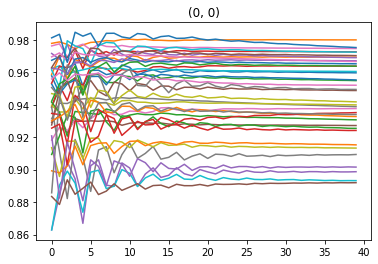

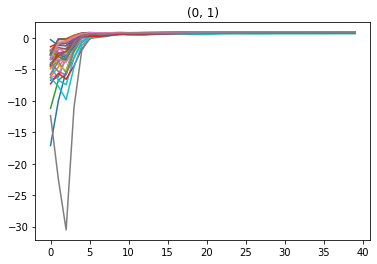

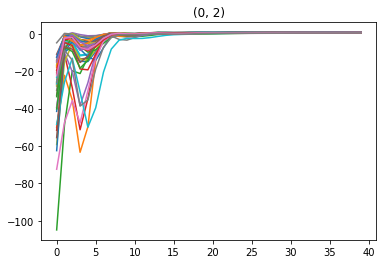

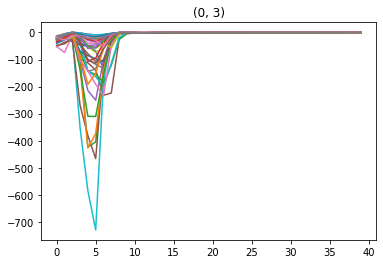

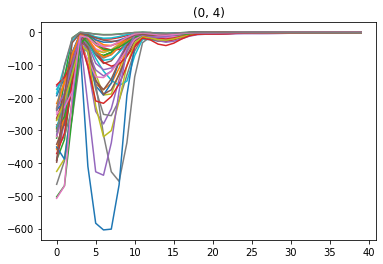

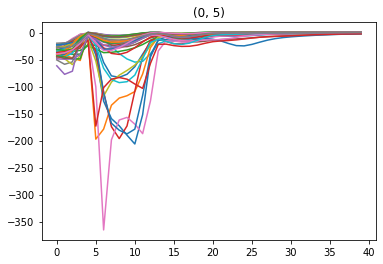

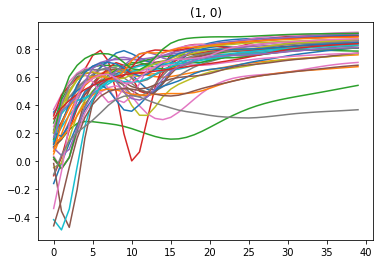

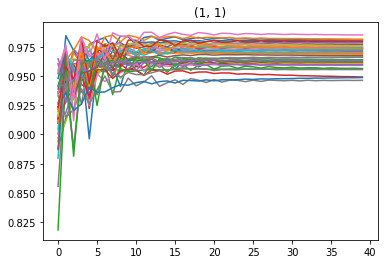

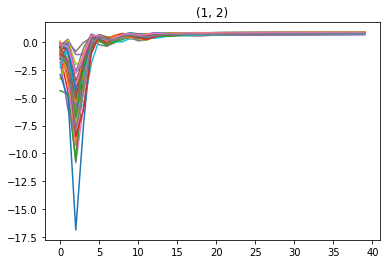

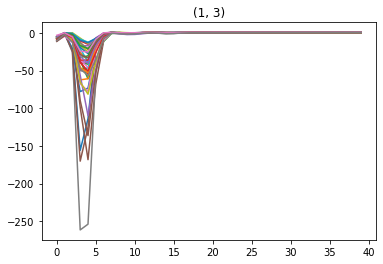

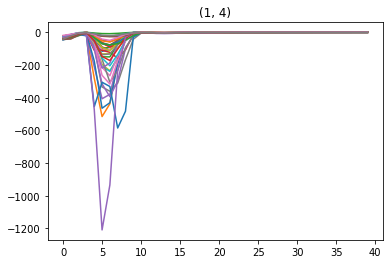

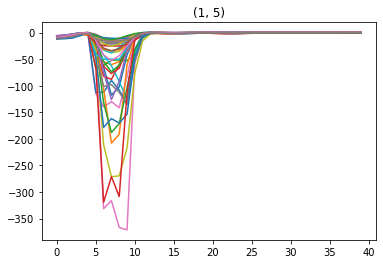

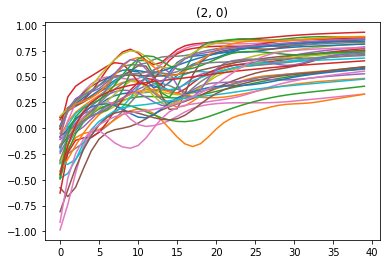

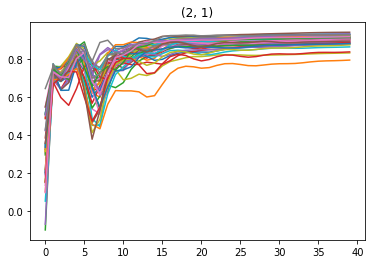

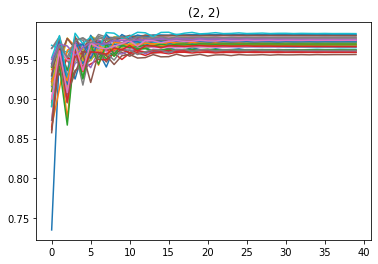

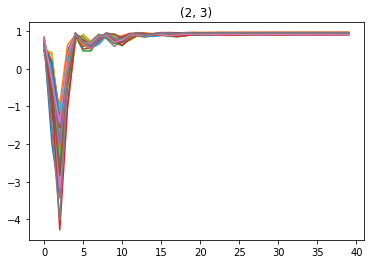

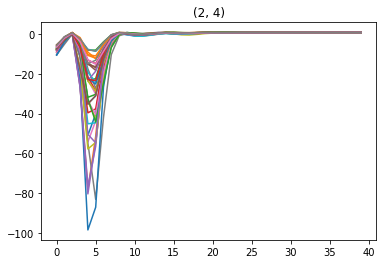

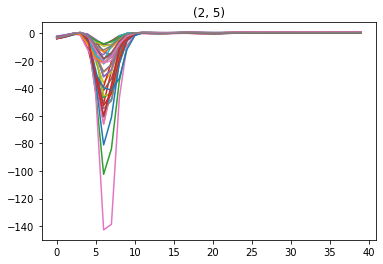

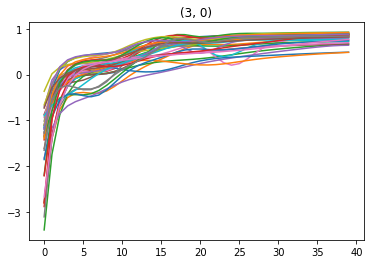

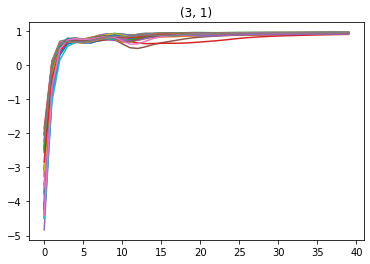

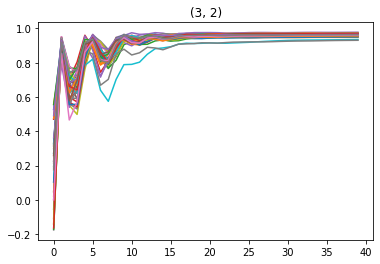

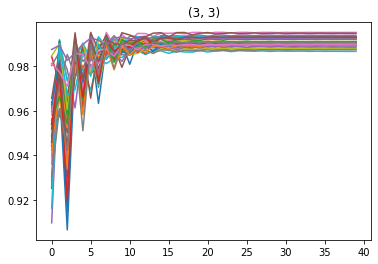

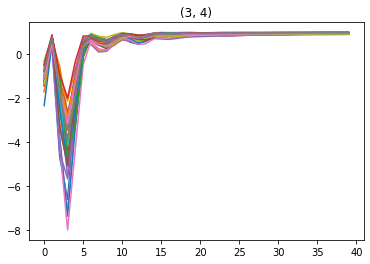

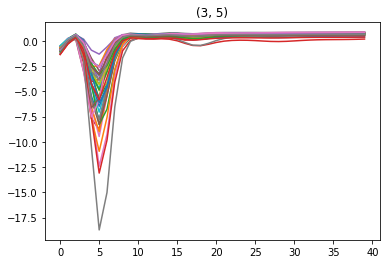

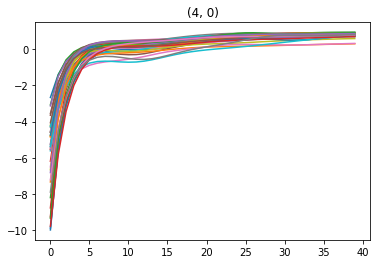

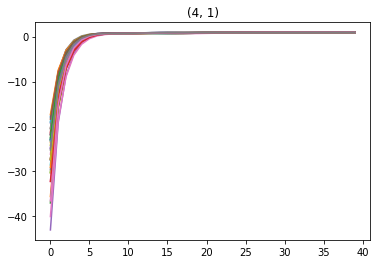

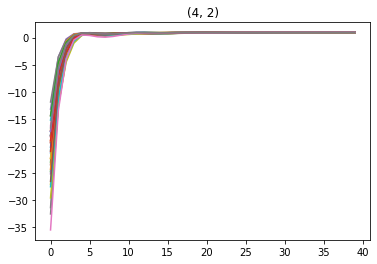

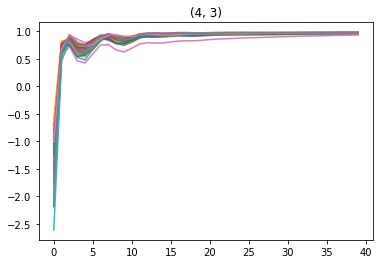

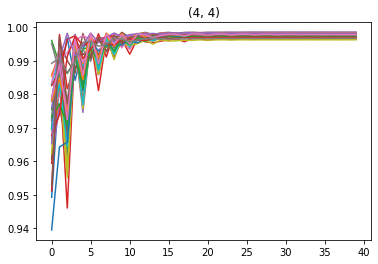

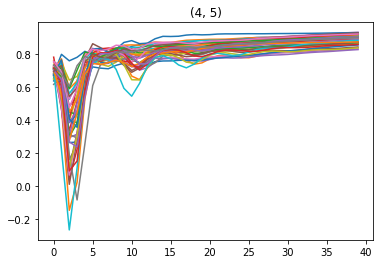

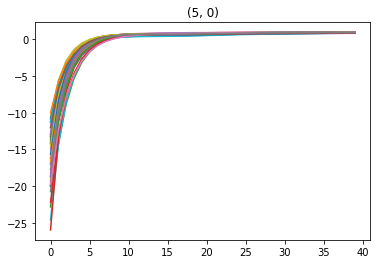

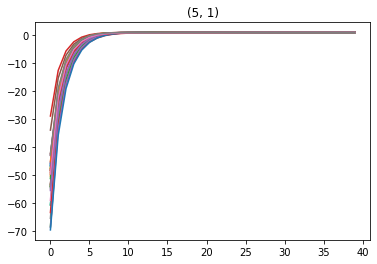

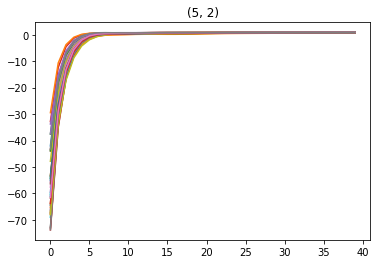

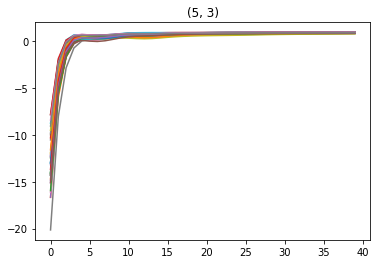

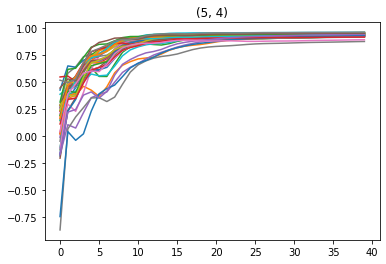

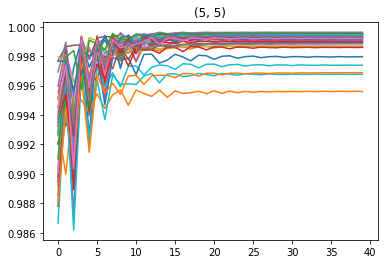

In [15]:
for z in dic:
    for i in range(len(dic[z])):
        plt.title(z)
        plt.plot(dic[z][i][:40])
    plt.show()

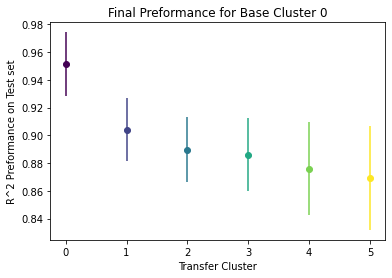

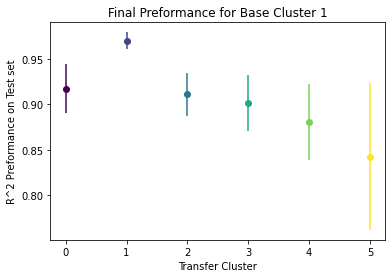

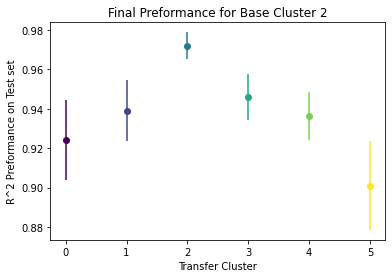

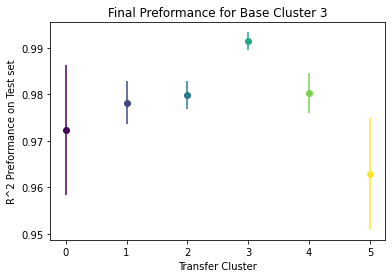

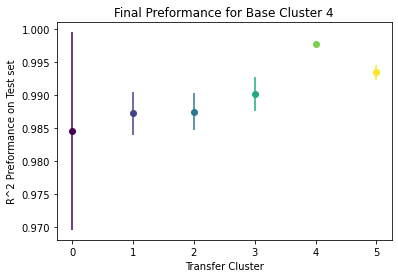

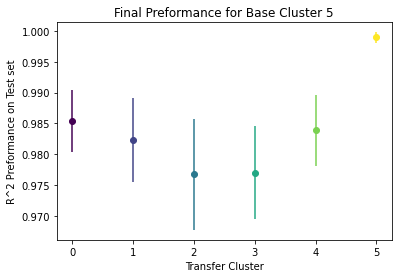

In [16]:
#Cluster_colors=["purple","b","steelblue","teal","lime","gold"]
last=0
adjust=53
Up_max=[]
for i in dic:
    f_index=i[0]
    if f_index is not last:
        for count,z in enumerate(Up_max):
            plt.errorbar(count,z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count])
        plt.title(f"Final Preformance for Base Cluster {f_index-1}")
        plt.ylabel("R^2 Preformance on Test set")
        plt.xlabel("Transfer Cluster")
        plt.show()
        Up_max=[]
    store_max=[]
    store_all=[]
    for count,g in enumerate(dic[i]):
        if count==0:
            store_all=np.array(g)
        else:
            store_all=store_all+np.array(g)
        store_max.append(max(g))
    store_max=np.array(store_max)
    store_all=np.array(store_all)
    dic2[i].append((store_all/adjust))
    Up_max.append(store_max)
    last=f_index
for count,z in enumerate(Up_max):
    plt.errorbar(count,z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count])
plt.title(f"Final Preformance for Base Cluster {5}")
plt.ylabel("R^2 Preformance on Test set")
plt.xlabel("Transfer Cluster")
plt.show()

In [ ]:
dif_holder=[]
std_diff=[]
overfit_holder=[]
residual_holder=[]
std_res=[]
integral_holder=[]
std_int=[]
last=0
difference=.1
GB=True
for i in dic2:
    f_index=i[0]
    #integral and residual 
    y=(max(dic2[i][0]))-dic2[i][0]
    x=np.linspace(1,epochs,resolution)
    index=np.where(y<(difference))
    ### overfit
    #std_test
    sy=(max(dic2[i][0]+std_store[i]))-dic2[i][0]+std_store[i]
    sx=np.linspace(1,epochs,resolution)
    sindex=np.where(sy<(difference))
    #regular diffs
    diff=max(dic2[i][0])-min(dic2[i][0])
    std1=std_store[i][0]
    #overfit test
    overfit=(dic2[i][0][0]-dic2[i][0][-1]) > 0
    if f_index is not last:
        for count,z in enumerate(dif_holder):
            if overfit_holder[count]:
                plt.errorbar(count,-z,marker="x",c=Cluster_colors[count],yerr=std_diff[count])
            else:
                plt.errorbar(count,z,marker="o",c=Cluster_colors[count],yerr=std_diff[count])
        plt.title(f"Average Training Deviation on Initial Epoch for Base {i[0]-1}")
        plt.ylabel("R^2 deviation from best preforming model")
        plt.xlabel("Transfer Cluster")
        plt.show()
        for count,f in enumerate(residual_holder):
            conversion=epoch_conversions[count]
            f=f*epoch_conversions[count]
            plt.ylabel("Datapoints")
            if GB:
                conversion=conversion*byte*0.000001
                f=f*byte*0.000001 #mega bytes
                plt.ylabel("MegaBytes")
            plt.errorbar(count,f,c=Cluster_colors[count],yerr=std_res[count]*conversion,fmt="o")
        plt.title(f"Average Imformation to reach {difference*100} % Deviation Base {i[0]-1}")
        plt.xlabel("Transfer Cluster")
        plt.show()
        for count,f in enumerate(integral_holder):
            plt.errorbar(count,f,c=Cluster_colors[count],yerr=std_int[count],fmt="o")
        plt.title(f"Integral {difference*100} % Deviation Base {i[0]-1} ")
        plt.ylabel("Net R^2 deviation squared")
        plt.xlabel("Transfer Cluster")
        plt.show()
        dif_holder=[]
        std_diff=[]
        overfit_holder=[]
        residual_holder=[]
        std_res=[]
        integral_holder=[]
        std_int=[]
    dif_holder.append(diff)
    std_diff.append(std1)
    overfit_holder.append(overfit)
    try:
        first=index[0][0]
        sfirst=index[0][0]
        integral=scipy.integrate.simps(y[:first], x=x[:first], dx=1, axis=-1, even='first')
        sintegral=scipy.integrate.simps(sy[:sfirst], x=sx[:sfirst], dx=1, axis=-1, even='first')
        integral_holder.append(integral)
        std_int.append(sintegral-integral)
        print(integral,sintegral,sx[sfirst],x[first])
        residual_holder.append(x[first])
        std_res.append(sx[sfirst]-x[first])
    except:
        print("error", i)
        integral_holder.append(0)
        std_int.append(0)
        residual_holder.append(0)
        std_res.append(0)
    last=f_index
for count,z in enumerate(dif_holder):
    if overfit_holder[count]:
        plt.errorbar(count,-z,marker="x",c=Cluster_colors[count],yerr=std_diff[count])
    else:
        plt.errorbar(count,z,marker="o",c=Cluster_colors[count],yerr=std_diff[count])
plt.title(f"Average Training Deviation on Initial Epoch for Base {5}")
plt.ylabel("R^2 deviation from best preforming model")
plt.xlabel("Transfer Cluster")
plt.show()
for count,i in enumerate(residual_holder):
    coversion=epoch_conversions[count]
    i=i*epoch_conversions[count]
    plt.ylabel("Datapoints")
    if GB:
        conversion=conversion*byte*0.000001
        i=i*byte*0.000001 #mega bytes
        plt.ylabel("MegaBytes")
    plt.errorbar(count,i,c=Cluster_colors[count],yerr=std_res[count]*conversion,fmt="o")
plt.title(f"Average Imformation to reach {difference*100} % Deviation Base {5}")
plt.xlabel("Transfer Cluster")
plt.show()
for count,f in enumerate(integral_holder):
    plt.errorbar(count,f,c=Cluster_colors[count],yerr=std_int[count],fmt="o")
plt.title(f"Average Training time to reach {difference*100} % Deviation Base {5} ")
plt.ylabel("Net R^2 deviation squared")
plt.xlabel("Transfer Cluster")
plt.show()

In [66]:
epoch_conversions=[]
byte=df_train.iloc[0].memory_usage()
for i in M_Cluster:
    epoch_conversions.append(len(i))

In [ ]:
import scipy
for i in dic2:
    y=(max(dic2[i][0]))-dic2[i][0]
    x=np.linspace(1,epochs,resolution)
    index=np.where(y<(.2))
    print(x[:10],y[:10])
    try:
        first=index[0][0]
        plt.plot(x,y)
        plt.scatter(x[first],y[first])
        plt.title(i)
        plt.plot((max(dic2[i][0]+std_store[i]))-dic2[i][0]+std_store[i])
        plt.show()
        integral=scipy.integrate.simps(y[:first], x=x[:first], dx=1, axis=-1, even='first')
        print(i,x[first])
        print(integral)
    except:
        print("error", i)

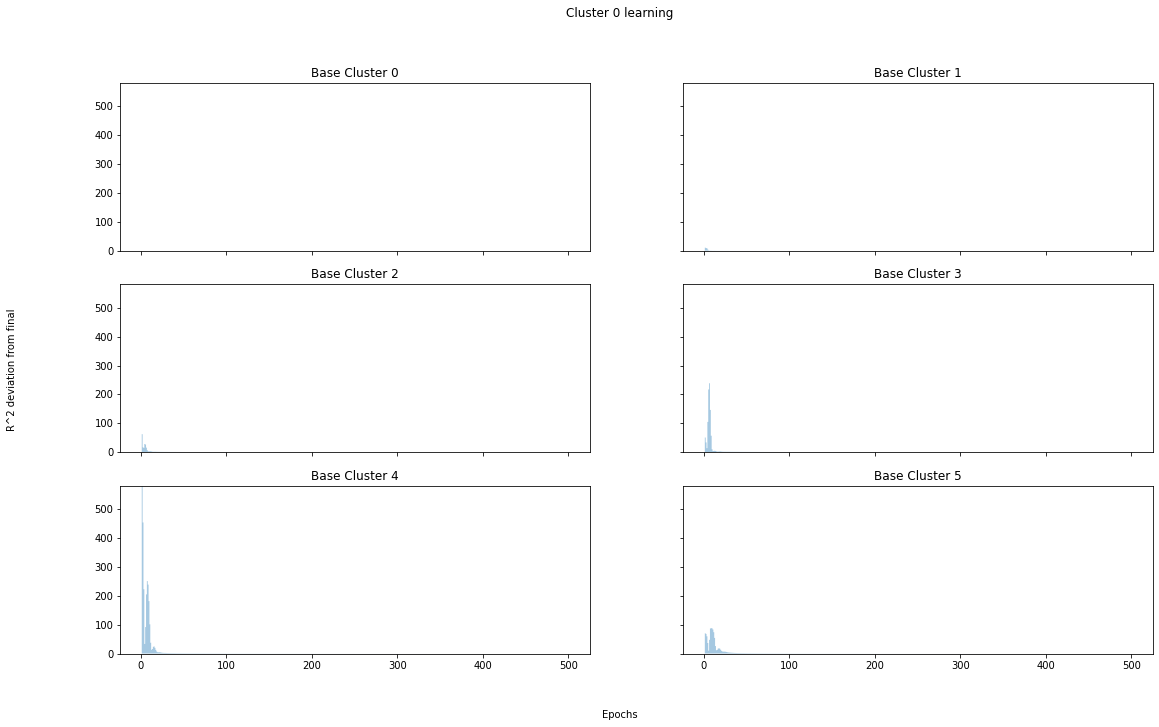

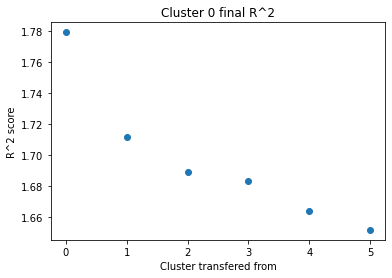

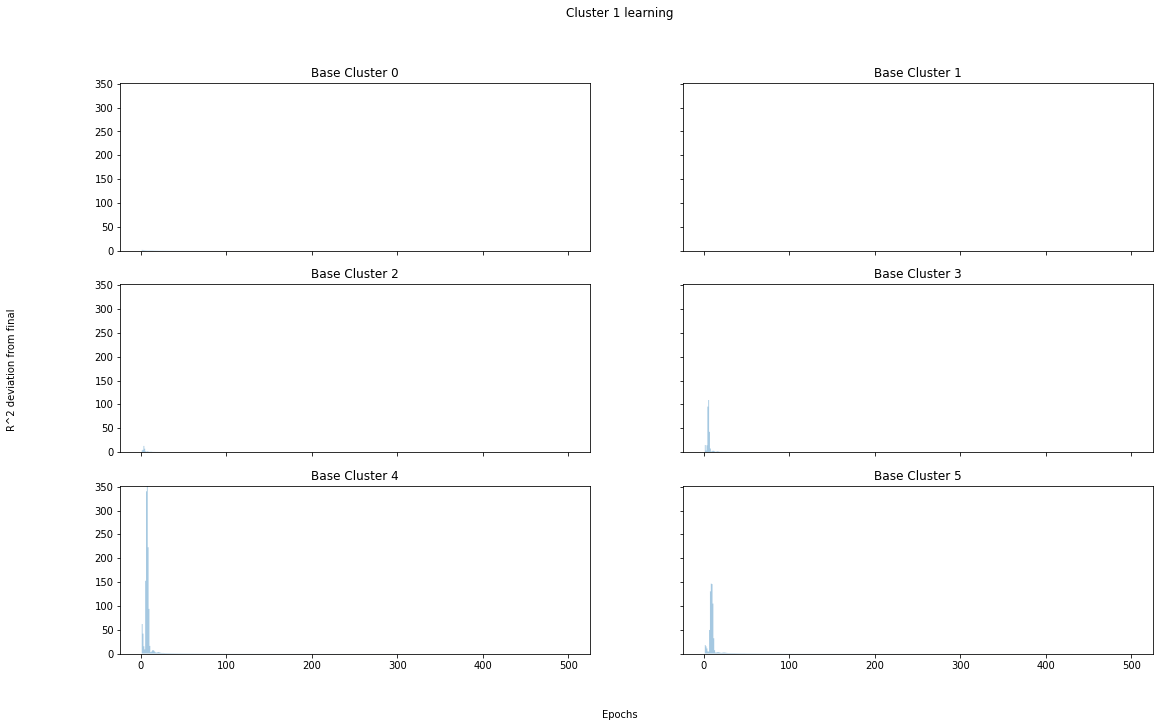

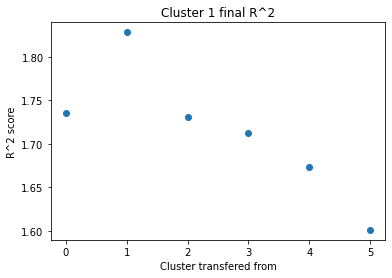

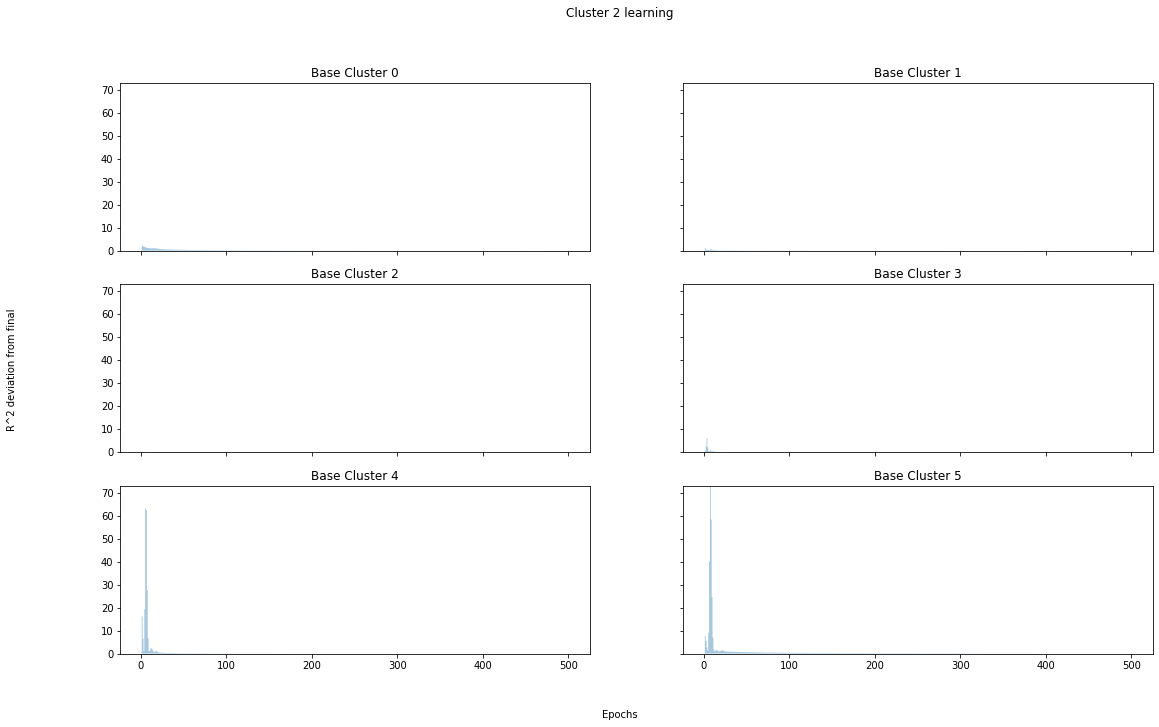

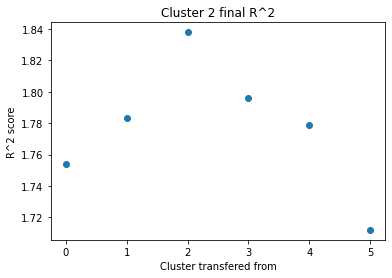

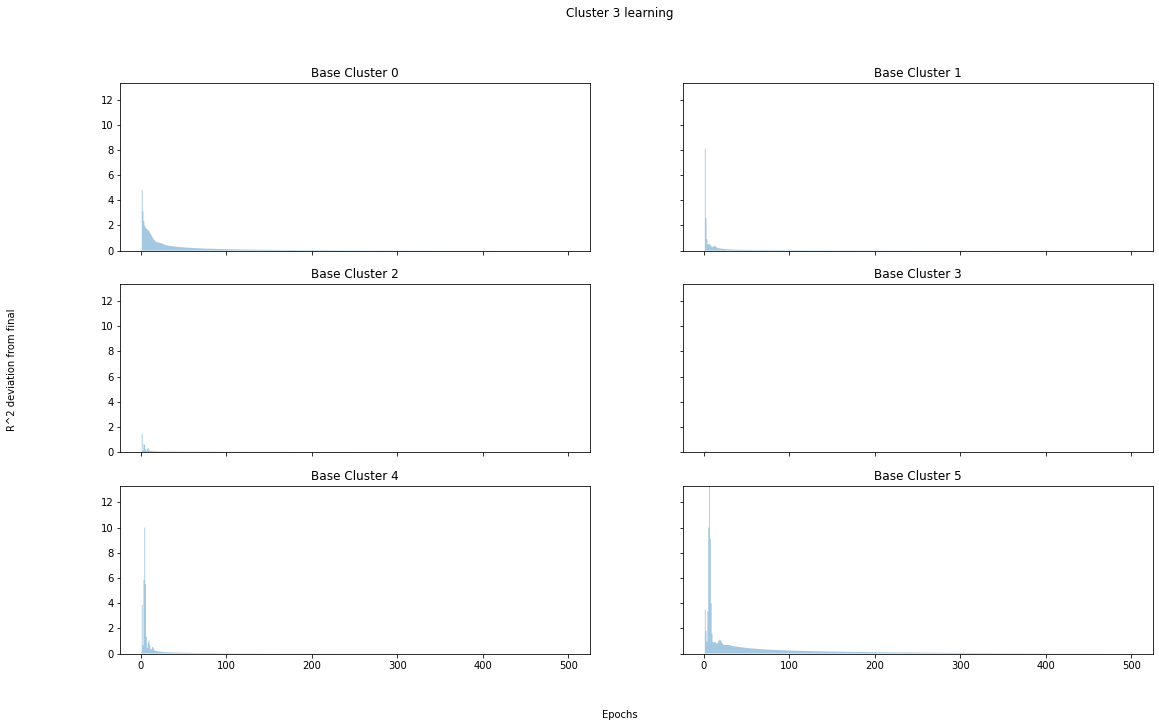

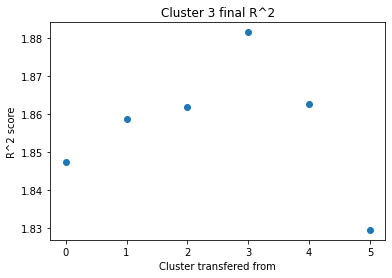

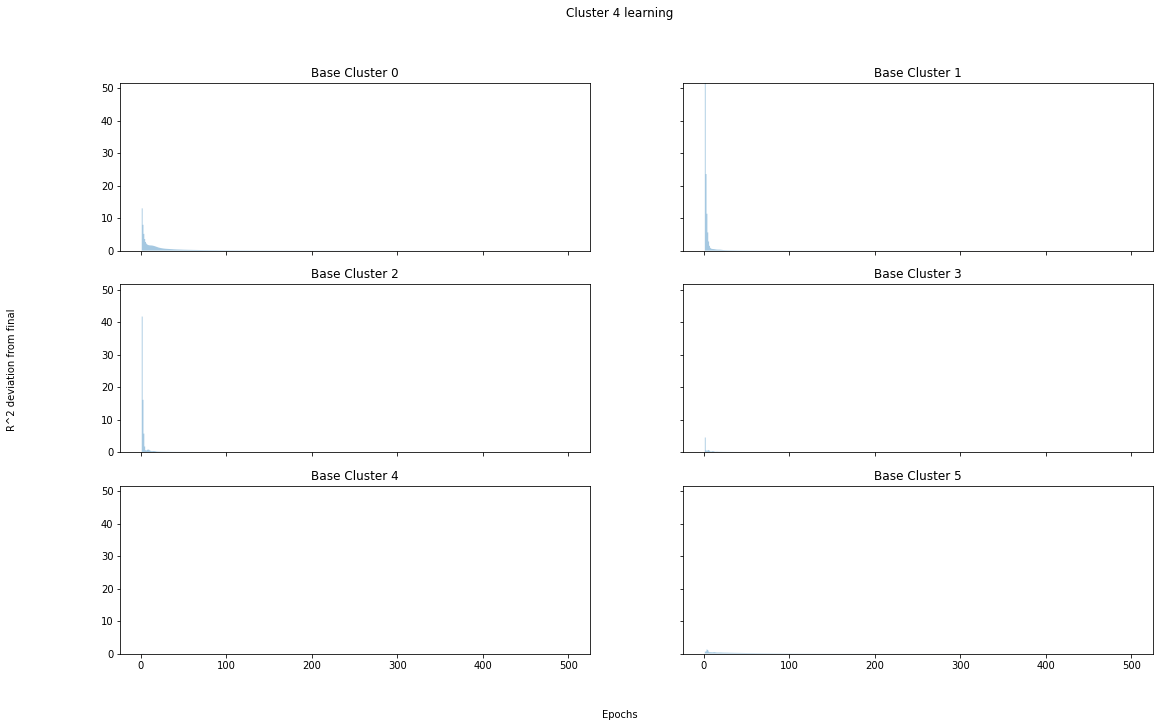

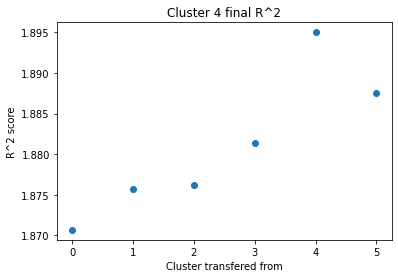

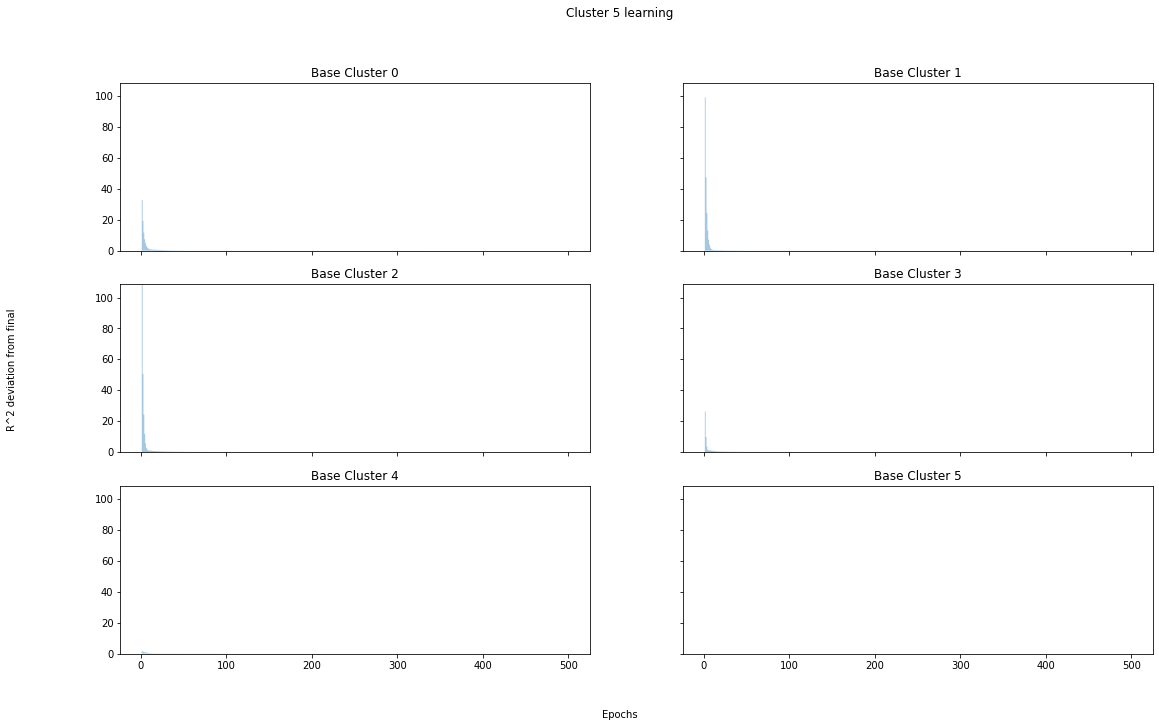

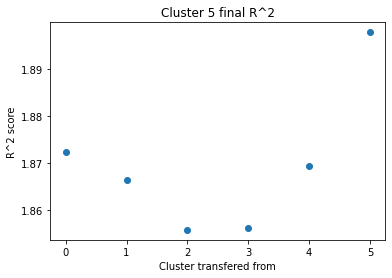

In [27]:
base={}
std={}
for count,i in enumerate((meta[0])):
    i=meta[0][i]
    base[count]=(i)
for i in meta[1:]:
    for g in i:
        for count,z in enumerate(i[g]):
            base[g][count]=np.array(base[g][count])+np.array(z)
anaylsis(base,adjust=20)

,Pc1,Pc2
Cluster,,
0,-3.544039,3.418156
1,-2.759969,0.638465
2,-1.570916,-0.855064
3,-0.129714,-0.473748
4,1.291237,-0.044567
5,2.664458,0.756521


In [35]:
import pandas as pd
from scipy.spatial import distance_matrix
hold=pd.DataFrame()
hold[['Pc1',"Cluster"]]=abridge[['Pc1',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())

,Pc1
Cluster,
0,-3.544039
1,-2.759969
2,-1.570916
3,-0.129714
4,1.291237
5,2.664458


IndentationError: expected an indented block (1373797849.py, line 1)

,Pc1,Pc2
Cluster,,
0,-3.544039,3.418156
1,-2.759969,0.638465
2,-1.570916,-0.855064
3,-0.129714,-0.473748
4,1.291237,-0.044567
5,2.664458,0.756521


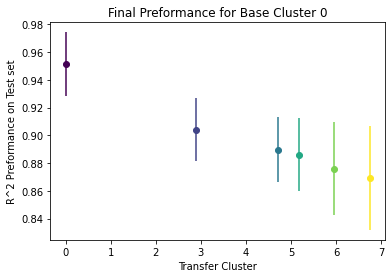

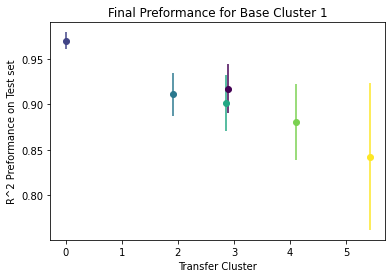

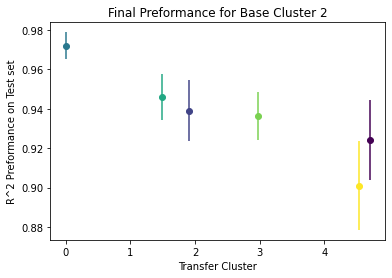

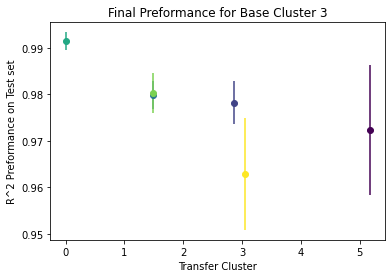

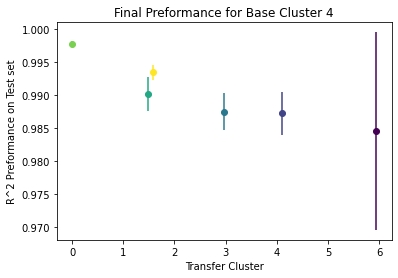

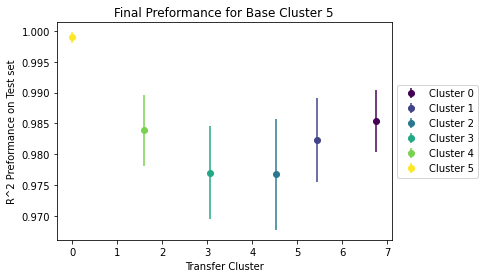

In [42]:
import pandas as pd
from scipy.spatial import distance_matrix
hold=pd.DataFrame()
hold[['Pc1', 'Pc2',"Cluster"]]=abridge[['Pc1', 'Pc2',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
#Cluster_colors=["purple","b","steelblue","teal","lime","gold"]
last=0
adjust=53
Up_max=[]
for i in dic:
    f_index=i[0]
    if f_index is not last:
        for count,z in enumerate(Up_max):
            temp=distances[f_index-1]
            plt.errorbar(temp[count],z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count])
        plt.title(f"Final Preformance for Base Cluster {f_index-1}")
        plt.ylabel("R^2 Preformance on Test set")
        plt.xlabel("Transfer Cluster")
        plt.show()
        Up_max=[]
    store_max=[]
    store_all=[]
    for count,g in enumerate(dic[i]):
        if count==0:
            store_all=np.array(g)
        else:
            store_all=store_all+np.array(g)
        store_max.append(max(g))
    store_max=np.array(store_max)
    store_all=np.array(store_all)
    dic2[i].append((store_all/adjust))
    Up_max.append(store_max)
    last=f_index
for count,z in enumerate(Up_max):
    temp=distances[len(distances)-1]
    plt.errorbar(temp[count],z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count],label=f"Cluster {count}")
plt.title(f"Final Preformance for Base Cluster {5}")
plt.ylabel("R^2 Preformance on Test set")
plt.xlabel("Transfer Cluster")
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

,Pc1
Cluster,
0,-3.544039
1,-2.759969
2,-1.570916
3,-0.129714
4,1.291237
5,2.664458


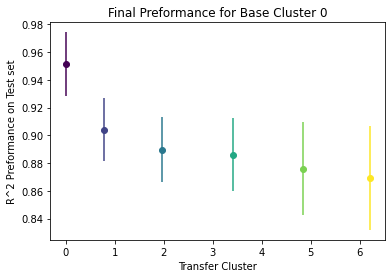

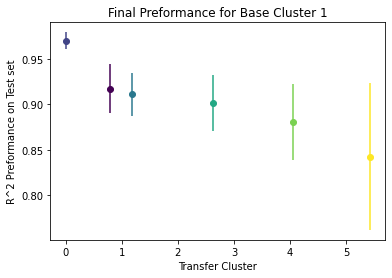

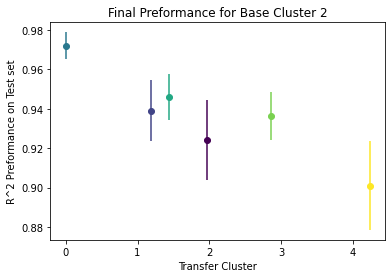

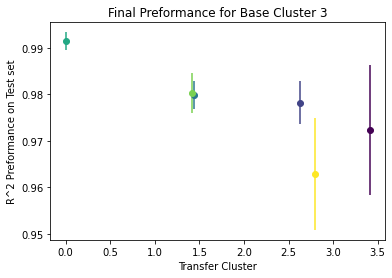

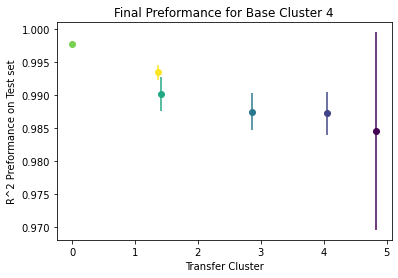

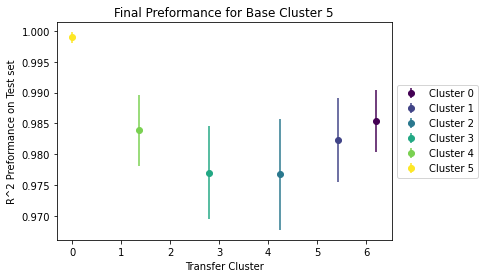

In [44]:
import pandas as pd
from scipy.spatial import distance_matrix
hold=pd.DataFrame()
hold[['Pc1',"Cluster"]]=abridge[['Pc1',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
#Cluster_colors=["purple","b","steelblue","teal","lime","gold"]
last=0
adjust=53
Up_max=[]
for i in dic:
    f_index=i[0]
    if f_index is not last:
        for count,z in enumerate(Up_max):
            temp=distances[f_index-1]
            plt.errorbar(temp[count],z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count])
        plt.title(f"Final Preformance for Base Cluster {f_index-1}")
        plt.ylabel("R^2 Preformance on Test set")
        plt.xlabel("Transfer Cluster")
        plt.show()
        Up_max=[]
    store_max=[]
    store_all=[]
    for count,g in enumerate(dic[i]):
        if count==0:
            store_all=np.array(g)
        else:
            store_all=store_all+np.array(g)
        store_max.append(max(g))
    store_max=np.array(store_max)
    store_all=np.array(store_all)
    dic2[i].append((store_all/adjust))
    Up_max.append(store_max)
    last=f_index
for count,z in enumerate(Up_max):
    temp=distances[len(distances)-1]
    plt.errorbar(temp[count],z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count],label=f"Cluster {count}")
plt.title(f"Final Preformance for Base Cluster {5}")
plt.ylabel("R^2 Preformance on Test set")
plt.xlabel("Transfer Cluster")
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

,Pc2
Cluster,
0,3.418156
1,0.638465
2,-0.855064
3,-0.473748
4,-0.044567
5,0.756521


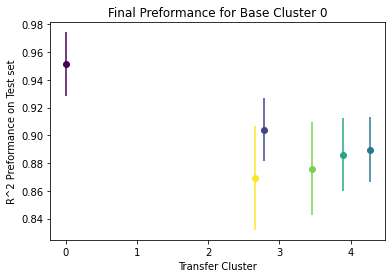

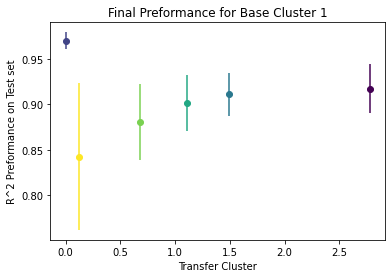

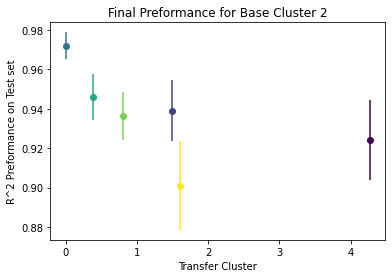

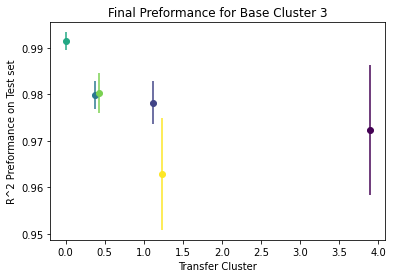

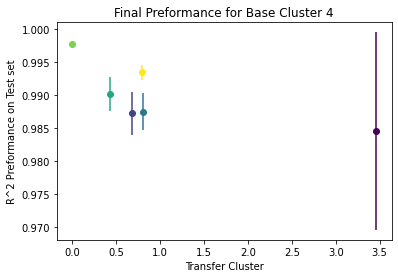

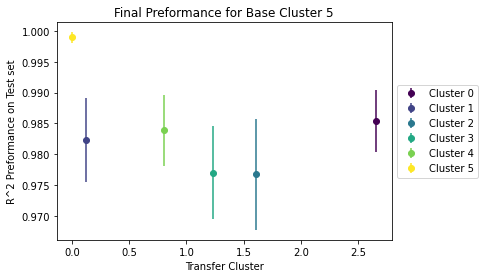

In [45]:
import pandas as pd
from scipy.spatial import distance_matrix
hold=pd.DataFrame()
hold[['Pc2',"Cluster"]]=abridge[['Pc2',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
#Cluster_colors=["purple","b","steelblue","teal","lime","gold"]
last=0
adjust=53
Up_max=[]
for i in dic:
    f_index=i[0]
    if f_index is not last:
        for count,z in enumerate(Up_max):
            temp=distances[f_index-1]
            plt.errorbar(temp[count],z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count])
        plt.title(f"Final Preformance for Base Cluster {f_index-1}")
        plt.ylabel("R^2 Preformance on Test set")
        plt.xlabel("Transfer Cluster")
        plt.show()
        Up_max=[]
    store_max=[]
    store_all=[]
    for count,g in enumerate(dic[i]):
        if count==0:
            store_all=np.array(g)
        else:
            store_all=store_all+np.array(g)
        store_max.append(max(g))
    store_max=np.array(store_max)
    store_all=np.array(store_all)
    dic2[i].append((store_all/adjust))
    Up_max.append(store_max)
    last=f_index
for count,z in enumerate(Up_max):
    temp=distances[len(distances)-1]
    plt.errorbar(temp[count],z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count],label=f"Cluster {count}")
plt.title(f"Final Preformance for Base Cluster {5}")
plt.ylabel("R^2 Preformance on Test set")
plt.xlabel("Transfer Cluster")
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()